In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)


In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28c51496488>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28c514ad908>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# First calculate the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date[0]

'2017-08-23'

In [13]:
# Convert the last_date to datetime format
last_date_dt=dt.datetime.strptime(last_date[0],'%Y-%m-%d')
last_date_dt

datetime.datetime(2017, 8, 23, 0, 0)

In [14]:
# Now, we can calculate the date one year ago from our last_date
year_ago=last_date_dt-dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [15]:
# Perform a query to retrieve the data and precipitation scores
precipitation=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
precipitation[0]

('2016-08-24', 0.08)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation)
precipitation_df=precipitation_df.set_index("date")
precipitation_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


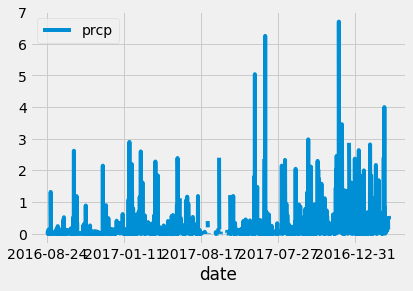

In [17]:
# Sort the dataframe by date
precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station=station_activity[0].station
most_active_station


'USC00519281'

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_tobs=session.query(func.min(Measurement.tobs)).all()
max_tobs=session.query(func.max(Measurement.tobs)).all()
avg_tobs=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()
print(f"The lowest temperature recorded is {min_tobs} degrees F")
print(f"The highest temperature recorded is {max_tobs} degrees F")
print(f"The average temperature recorded in the most active station is {avg_tobs} degrees F")

The lowest temperature recorded is [(53.0,)] degrees F
The highest temperature recorded is [(87.0,)] degrees F
The average temperature recorded in the most active station is [(71.66378066378067,)] degrees F


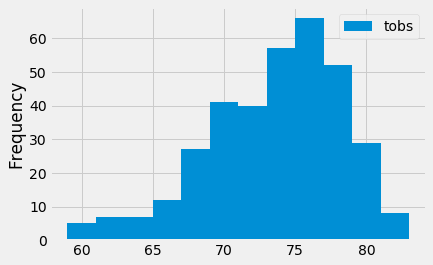

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_tobs=session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).\
        filter(Measurement.date > year_ago).\
        filter(Measurement.date < last_date_dt).all()
df = pd.DataFrame(active_tobs)
df.plot.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_values=(calc_temps(year_ago, last_date_dt))
print(temp_values)

[(58.0, 74.57894736842105, 87.0)]


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin=temp_values[0][0]
tavg=int(temp_values[0][1])
tmax=temp_values[0][2]
tdiff=tmax-tmin

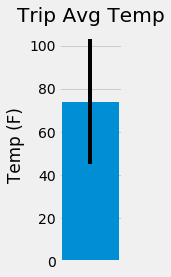

In [26]:
fig, ax = plt.subplots(figsize=(1,4))
ax.bar(x=0,height=tavg,width=1,yerr=tdiff)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temp (F)")
ax.set_xticks([])
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
           
prcp_totals=session.query(Station.station
                          , Station.name
                          , Station.latitude
                          , Station.longitude
                          , Station.elevation
                          , Measurement.station
                          , func.sum(Measurement.prcp)).\
                            group_by(Measurement.station).\
                            filter(Measurement.station==Station.station).\
                            filter(Measurement.date >= year_ago).\
                            filter(Measurement.date <= last_date_dt).\
                            order_by(func.sum(Measurement.prcp).desc()).all()
prcp_totals

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  'USC00516128',
  147.11000000000004),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  'USC00519281',
  68.24000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  'USC00513117',
  48.36000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  'USC00519523',
  37.99),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  'USC00514830',
  33.19),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  'USC00519397',
  16.089999999999986),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  'USC00517948',
  4.59)]

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.datetime.strptime("12-26-2020",'%m-%d-%Y')
end_date=dt.datetime.strptime("01-02-2021",'%m-%d-%Y')

# Use the start and end date to create a range of dates
trip_days=pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
month_day=trip_days.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

for day in month_day:
    normal=daily_normals(day)[0]
    normals.append(normal)

normals

[(63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0),
 (62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0)]

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

conditions_df=pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
conditions_df["date"] = trip_days
conditions_df=conditions_df.set_index(["date"])
conditions_df

,tmin,tavg,tmax
date,,,
2020-12-26,63.0,71.446809,77.0
2020-12-27,62.0,71.916667,79.0
2020-12-28,62.0,70.520833,77.0
2020-12-29,57.0,70.291667,78.0
2020-12-30,63.0,69.863636,76.0
2020-12-31,56.0,68.279070,77.0
2021-01-01,62.0,69.153846,77.0
2021-01-02,60.0,69.396226,77.0


Text(0, 0.5, 'Temperature (F)')

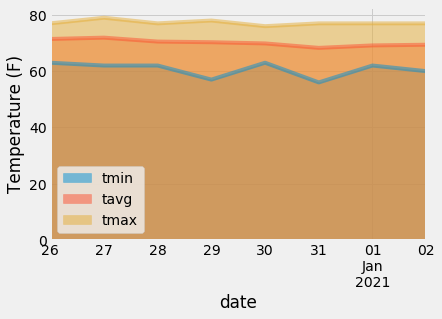

In [31]:
# Plot the daily normals as an area plot with `stacked=False`

conditions_df.plot.area(stacked=False)
plt.xlabel("date")
plt.ylabel("Temperature (F)")